# Testing of 2 UNet Pipeline

Main script for running inference and testing of our two UNet pipeline

In [27]:
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference
from monai.data import Dataset, CacheDataset, DataLoader
from monai.transforms import Activations

from grp_transforms import *
from grp_models import *

In [6]:
in_dir = 'data/nifti_files'
model_dir = 'data/task_results'

device = torch.device("cuda:0")
model = base_unet(device) # select model
transforms = unet2_baseline_transforms() # select transforms

/home/mjz-arabica/miniconda3/envs/ml/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)
/home/mjz-arabica/miniconda3/envs/ml/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [7]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

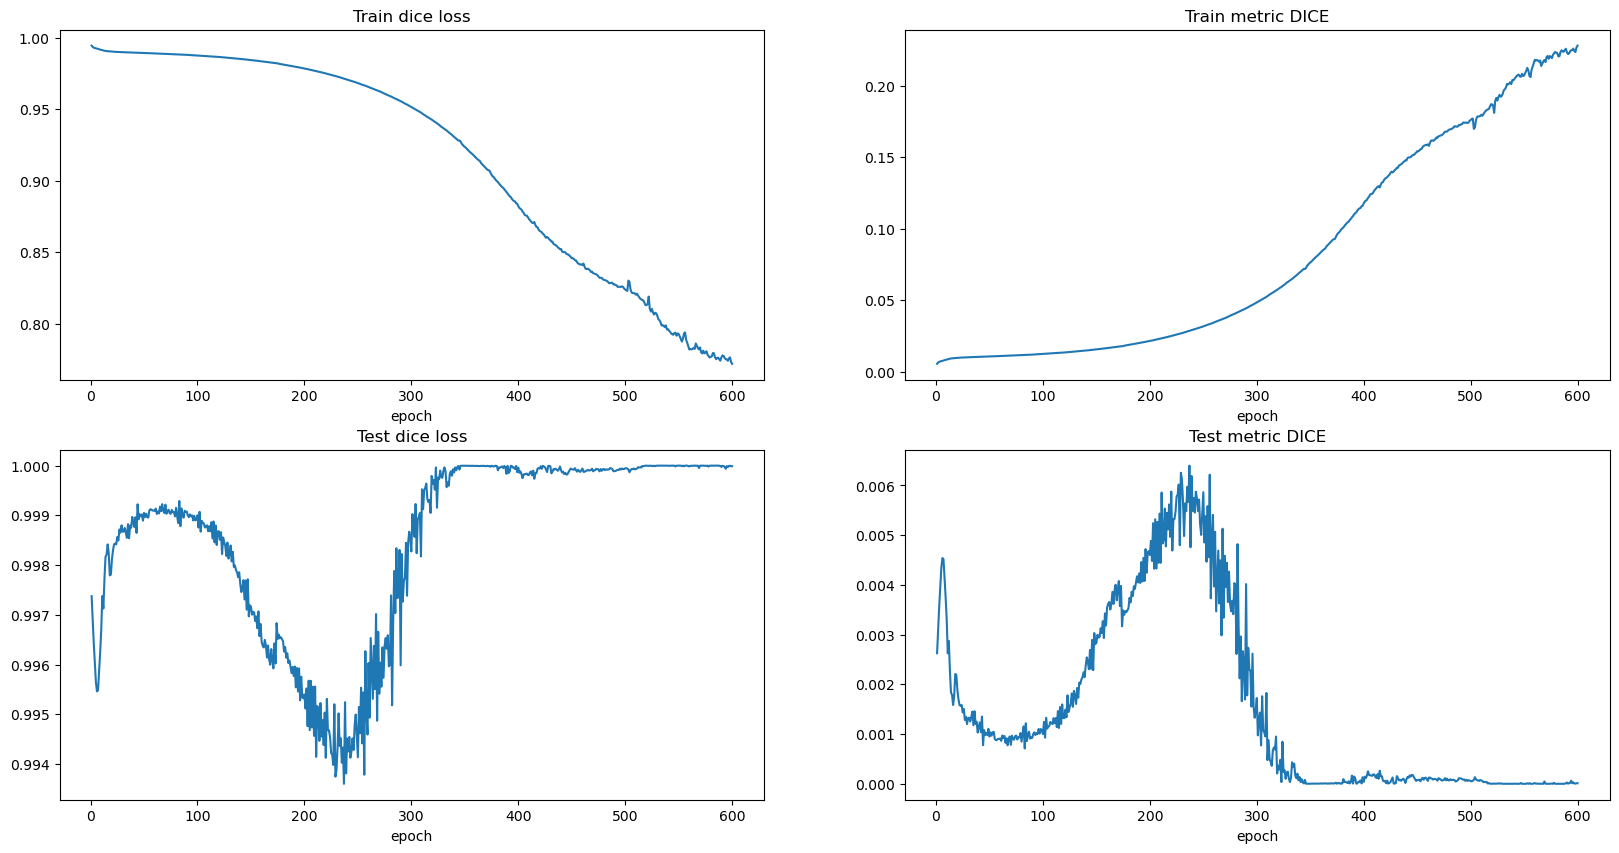

In [36]:
# display params
disp_size = 10
# plots
plt.figure("Training and Eval Losses", (disp_size * 2, disp_size))
# training DICE loss
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)
# training DICE metric
plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)
# testing DICE loss
plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)
# testing DICE metric
plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [37]:
def load_data(data_dir, transforms, sub_folder_images="images", sub_folder_labels="labels", cache=False):
    image_files = sorted(glob(data_dir + "/" + sub_folder_images + "/*.nii.gz")) # sorted by name to ensure match
    label_files = sorted(glob(data_dir + "/" + sub_folder_labels + "/*.nii.gz"))
    # sanity check: ensure names for both files matches
    for file_pair in zip(image_files, label_files):
        image_name, label_name = file_pair
        assert(os.path.basename(image_name) == os.path.basename(label_name))
    # create dict for volume and segmentation
    files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(image_files, label_files)]
    
    if cache:
        return CacheDataset(data=files, transform=transforms)
    return Dataset(data=files, transform=transforms)

dataset = load_data(in_dir, transforms=transforms)

In [22]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


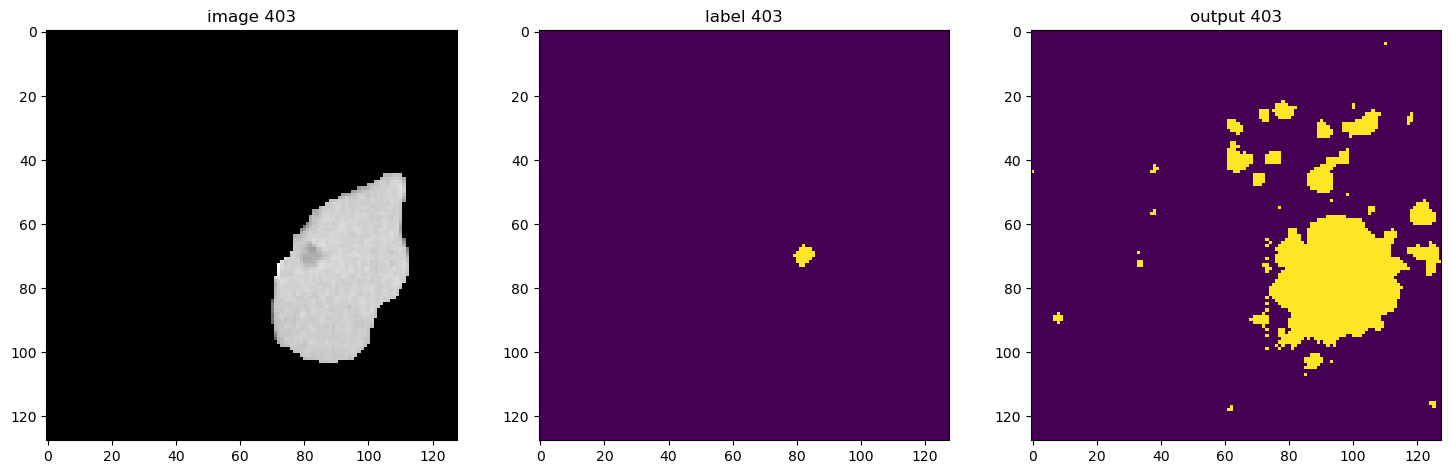

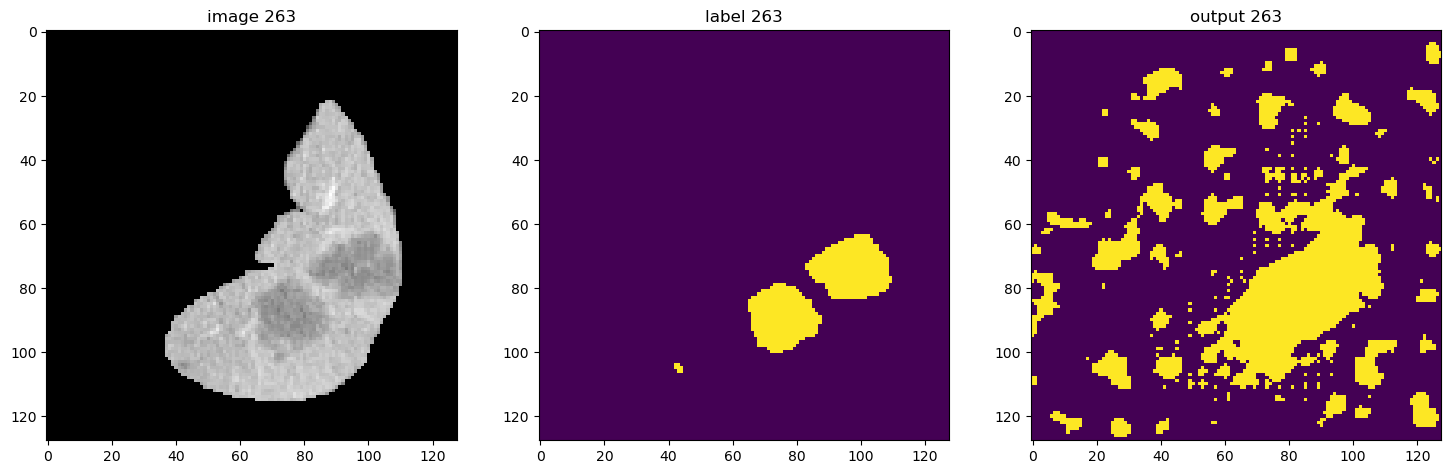

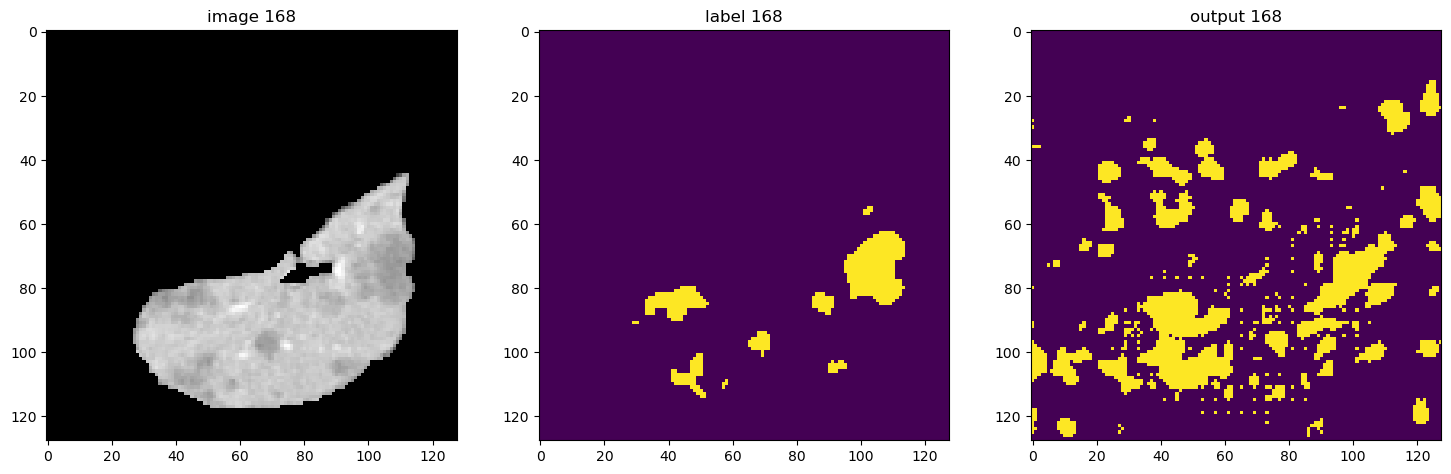

In [38]:
max_sw_batch_size = 4
roi_size = (128, 128, 64)
ind_to_test = [403, 263, 168]
sw_batch_size = min(max_sw_batch_size, len(ind_to_test))

testing_data = dataset[ind_to_test]

with torch.no_grad():
    loader = DataLoader(testing_data, batch_size=3)

    for test_patient in loader:
        t_volume = test_patient['vol']
        #t_segmentation = test_patient['seg']
        
        test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
        sigmoid_activation = Activations(sigmoid=True)
        test_outputs = sigmoid_activation(test_outputs)
        test_outputs = test_outputs > 0.53
            
        for i in range(len(ind_to_test)):
            # plot the slice [:, :, 80]
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {ind_to_test[i]}")
            plt.imshow(test_patient["vol"][i, 0, :, :, 0], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {ind_to_test[i]}")
            plt.imshow(test_patient["seg"][i, 0, :, :, 0] != 0)
            plt.subplot(1, 3, 3)
            plt.title(f"output {ind_to_test[i]}")
            plt.imshow(test_outputs.detach().cpu()[i, 0, :, :, 0])
            plt.show()

In [ ]:
# NOTE: DOES NOT WORK
# To check why the forward model call is not implemented
for ind in ind_to_test:
        raw_outputs = model.forward(dataset[ind]["vol"])
        print(raw_outputs)